In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os
from pycbc.types import timeseries
from calcwf import *

In [3]:
sample_rate = 4096

# Plot functions

## Other functions

In [121]:
def favata_et_al_avg(given_e, given_chirp, e_vals, f_low=10, q=2):

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd, _ = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-7/3), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssf/ss)**(-3/14)
    print('Average frequency: '+str(avg_f)+' Hz')
    s_given_e = shifted_e(avg_f, f_low, given_e)
    print(f'Given_e shifted from {given_e} to {s_given_e}')
    s_e_vals = shifted_e(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

In [122]:
def quad_sine_model(x, coeff_array):

    quad_total = 0
    for coeff_list in coeff_array:
        quad_total += (coeff_list[0]*np.sin(x+coeff_list[1])+coeff_list[2])**2

    return np.sqrt(quad_total)

## Target TA functions

In [123]:
def zero_default(wf_hjs, n, fid_e, fid_M, q, f_low, approximant):
    return 0

In [124]:
def get_TA_sine(wf_hjs, n, fid_e, fid_M, q, f_low, approximant):

    # Generate each TEOBResumS waveform and calculate matches
    sine_e = fid_e*1.1
    sine_chirp = favata_et_al_avg(fid_e, fid_M, sine_e, f_low, q)
    sine_s_f_max = f_low - shifted_f(f_low, sine_e, chirp2total(sine_chirp, q), q)
    sine_s_f_vals = np.linspace(f_low, f_low - 0.5*sine_s_f_max, 3)
    sine_s_e_vals = shifted_e(sine_s_f_vals, f_low, sine_e)
    mn_cplxs = []
    for sine_s_f, sine_s_e in zip(sine_s_f_vals, sine_s_e_vals):
        sine_wf = gen_wf(sine_s_f, sine_s_e, chirp2total(sine_chirp, q), q, sample_rate, approximant=approximant)
        mn_cplxs.append(match_hn(wf_hjs, sine_wf, f_low))

    # Calculate sine coeffs
    coeffs = []
    mn_cplxs = np.array(mn_cplxs).T
    for mn_cplx in mn_cplxs:
        coeffs.append(sine_model_coeffs(*np.abs(mn_cplx)))
    
    # Use location of peak of first sinusoid for initial guess
    init_guess = np.pi/2 - coeffs[0][1]
    if init_guess > 0:
        init_guess -= 2*np.pi

    # Set bounds and arguments of function
    args = ([np.array(coeffs)])
    bounds = [(-2*np.pi, 0)]

    # Perform maximisation
    max_result = minimize(lambda x: -quad_sine_model(x, *args), init_guess, bounds=bounds)
    max_location = max_result['x']

    # Calculate shift required by subtracting phase difference
    phase_diff = np.angle(mn_cplxs[1][0]) - np.angle(mn_cplxs[0][0])
    target_TA = max_location - phase_diff
    if target_TA > 0:
        target_TA -= 2*np.pi
    elif target_TA <= -2*np.pi:
        target_TA += 2*np.pi
    print(target_TA)

    return target_TA

## Calculate match functions

In [125]:
def no_maximisation(s, wf_hjs, e, chirp, n, fid_e, fid_M, q, f_low, approximant, target_TA):
    match_cplx = match_hn(wf_hjs, s, f_low)
    return match_cplx

In [126]:
def shift_h(s, wf_hjs, e, chirp, n, fid_e, fid_M, q, f_low, approximant, target_TA):

    # Calculate phase difference from initial match
    match_cplx = match_hn(wf_hjs, s, f_low)
    phase_diff = np.angle(match_cplx[1])-np.angle(match_cplx[0])+target_TA
    if phase_diff > 0:
        phase_diff -= 2*np.pi

    # Shift f and e by phase difference
    s_f_range = f_low - shifted_f(f_low, e, chirp2total(chirp, q), q)
    s_f = f_low + (phase_diff/(2*np.pi))*s_f_range
    s_e = shifted_e(s_f, f_low, e)

    # Recalculate match
    wf_s_f = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, approximant)
    match_cplx = match_hn(wf_hjs, wf_s_f, f_low)
    
    return match_cplx

In [127]:
def shift_h_pi(s, wf_hjs, e, chirp, n, fid_e, fid_M, q, f_low, approximant, target_TA):

    # Calculate phase difference from initial match
    match_cplx = match_hn(wf_hjs, s, f_low)
    phase_diff = np.angle(match_cplx[1])-np.angle(match_cplx[0])+np.pi+target_TA
    if phase_diff > 0:
        phase_diff -= 2*np.pi

    # Shift f and e by phase difference
    s_f_range = f_low - shifted_f(f_low, e, chirp2total(chirp, q), q)
    s_f = f_low + (phase_diff/(2*np.pi))*s_f_range
    s_e = shifted_e(s_f, f_low, e)

    # Recalculate match
    wf_s_f = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, approximant)
    match_cplx = match_hn(wf_hjs, wf_s_f, f_low)
    
    return match_cplx

In [128]:
def shift_hn(s, wf_hjs, e, chirp, n, fid_e, fid_M, q, f_low, approximant, target_TA):

    # Calculate phase difference from initial match
    match_cplx = match_hn(wf_hjs, s, f_low)
    phase_diff = np.angle(match_cplx[0])-np.angle(match_cplx[1])+target_TA
    if phase_diff > 0:
        phase_diff -= 2*np.pi

    # Shift f and e by phase difference
    s_f_range = f_low - shifted_f(f_low, fid_e, chirp2total(fid_M, q), q)
    s_f = f_low + (phase_diff/(2*np.pi))*s_f_range
    s_e = shifted_e(s_f, f_low, fid_e)

    # Recalculate match
    all_wfs = list(get_h([1]*n, s_f, s_e, chirp2total(fid_M, q), q, sample_rate, approximant=approximant))
    match_cplx = match_hn(all_wfs[1:n+1], s, f_low)
    
    return match_cplx

## General functions

In [129]:
def chirp_match_data(param_vals, n, fid_e, fid_M, q, f_low, approximant='TEOBResumS', TA_method=zero_default, match_method=no_maximisation, param='chirp', fixed_e=None):

     # Setup match dict and calculate conversion from chirp to total mass
    matches = {'diff_phase':[], 'quad':[]}
    for i in range(n):
            matches[f'h{i+1}'] = []
            matches[f'h{i+1}_phase'] = []

    # Generate fiducial waveform
    all_wfs = list(get_h([1]*n, f_low, fid_e, chirp2total(fid_M, q), q, sample_rate, approximant=approximant))
    wf_hjs = all_wfs[1:n+1]

    # Generate param values
    if param=='chirp':
        if fixed_e is None:
            fixed_e = fid_e
        e_vals = np.full(len(param_vals), fixed_e)
        chirp_vals = param_vals
    elif param=='ecc_chirp':
        e_vals = param_vals
        chirp_vals = favata_et_al_avg(fid_e, fid_M, e_vals, f_low=f_low, q=q)

    # TA to shift to
    target_TA = TA_method(wf_hjs, n, fid_e, fid_M, q, f_low, approximant)

    # Progress bar setup
    progress = 0
    gridsize = len(chirp_vals)
    
    # Loop over chirp mass values
    for e, chirp in zip(e_vals, chirp_vals):
        s = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, approximant=approximant)

        # Calculate matches with chosen method
        match_cplx = match_method(s, wf_hjs, e, chirp, n, fid_e, fid_M, q, f_low, approximant, target_TA)

        # Save matches
        match_quad_sqrd = 0
        for i in range(n):
            matches[f'h{i+1}'].append(abs(match_cplx[i]))
            matches[f'h{i+1}_phase'].append(np.angle(match_cplx[i]))
            match_quad_sqrd += abs(match_cplx[i])**2
        matches['diff_phase'].append(np.angle(match_cplx[0]) - np.angle(match_cplx[1]))
        matches['quad'].append(np.sqrt(match_quad_sqrd))

        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [130]:
# Plots match contours on eccentricity/chirp mass plot
def chirp_match_plot(param_vals, n, fid_e, fid_M, q, matches, labels, param='chirp', fixed_e=None):

    # Fixed parameter settings
    if fixed_e is None:
        fixed_e = fid_e
    fixed_dict = {'chirp': 'ecc', 'ecc_chirp': 'ecc chirp'}
    fixed = fixed_dict[param]
    truth_dict = {'chirp': fid_M, 'ecc_chirp': fid_e}
    truth = truth_dict[param]
    xlabel_dict = {'chirp': '$\mathcal{M}~/~M_\odot$', 'ecc_chirp': 'e'}
    xlabel = xlabel_dict[param]

    # Make contour plot for  each match
    keys = [f'h{i+1}' for i in range(n)]
    keys.append('quad')
    for i, key in enumerate(keys):

        # Plotting amplitude of matches against chirp mass
        for match, label in zip(matches, labels):
            plt.plot(param_vals, match[key], label=label)
        plt.axvline(truth, c='k', ls='dashed', zorder=5, alpha=0.7)
        ylim = plt.gca().get_ylim()
        plt.axhline(1, c='k', ls='dashed', zorder=5, alpha=0.7)
        plt.ylim(ylim)
        plt.xlabel(xlabel)
        plt.ylabel('match')
        plt.title(f'{key}, q={q}, fixed {fixed}')
        plt.legend()
        plt.xlim(param_vals[0], param_vals[-1])
        plt.show()

    # Plotting amplitude of matches against chirp mass
    for match, label in zip(matches, labels):
        plt.plot(param_vals, np.array(match['h2'])/np.array(match['h1']), label=label)
    plt.axvline(truth, c='k', ls='dashed', zorder=5, alpha=0.7)
    ylim = plt.gca().get_ylim()
    plt.axhline(1, c='k', ls='dashed', zorder=5, alpha=0.7)
    plt.ylim(ylim)
    plt.xlabel(xlabel)
    plt.ylabel('match')
    plt.title(f'h2/h1, q={q}, fixed {fixed}')
    plt.legend()
    plt.xlim(param_vals[0], param_vals[-1])
    plt.show()

# n=2, no maximisation, against chirp

In [52]:
start = time.time()
dataslot_0 = chirp_match_data(np.linspace(23,25,101), 2, 0.1, 24, 2, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

101 done out of 101
Time taken: 55.61672401428223 seconds.


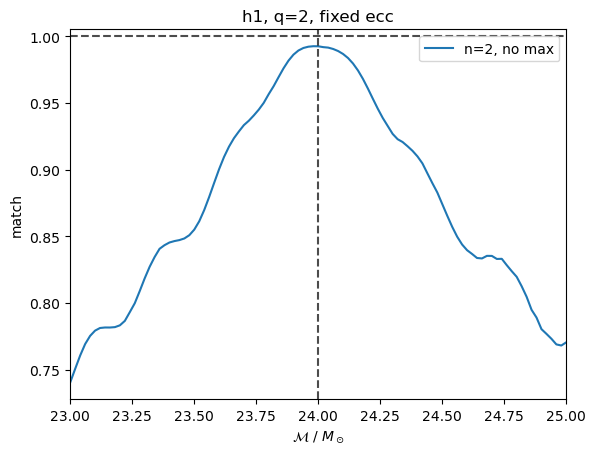

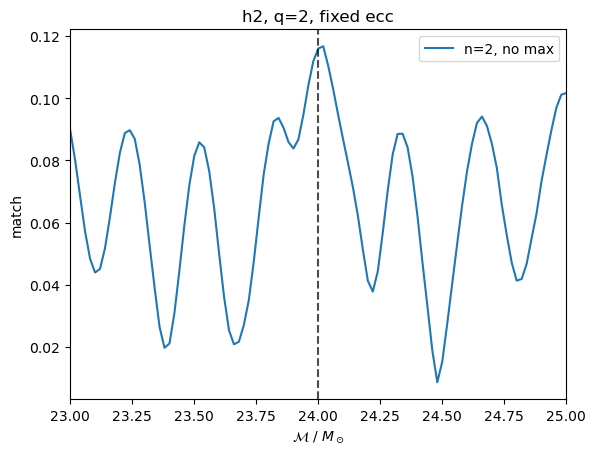

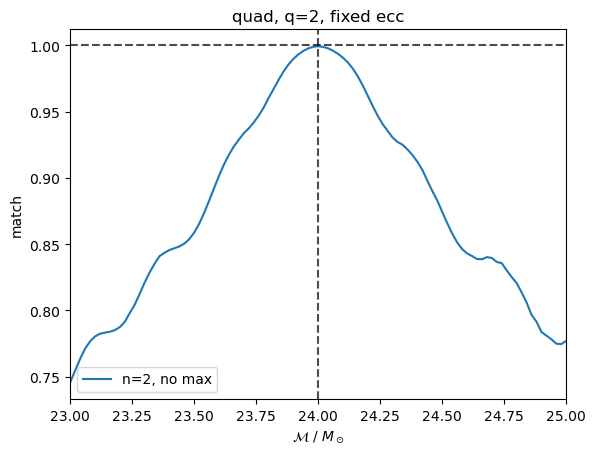

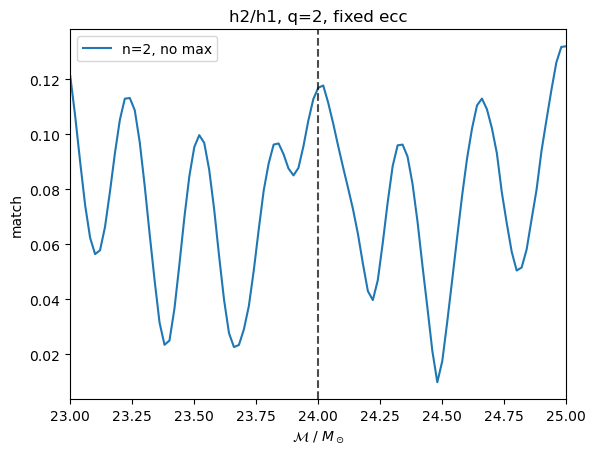

In [53]:
chirp_match_plot(np.linspace(23,25,101), 2, 0.1, 24, 2, [dataslot_0], ['n=2, no max'])

# n=4, no maximisation, against chirp

In [11]:
start = time.time()
dataslot_1 = chirp_match_data(np.linspace(23,25,101), 4, 0.1, 24, 2, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

101 done out of 101
Time taken: 61.682798624038696 seconds.


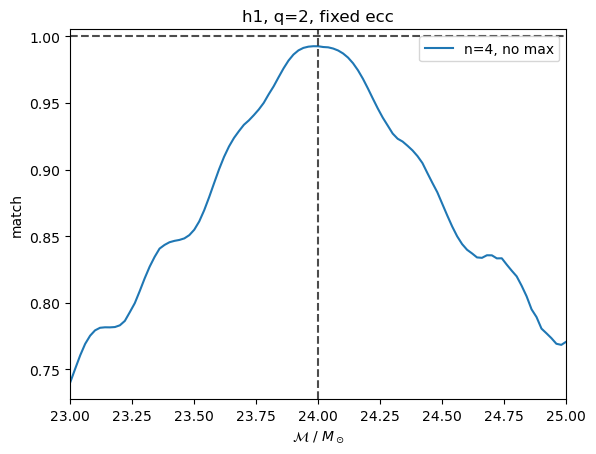

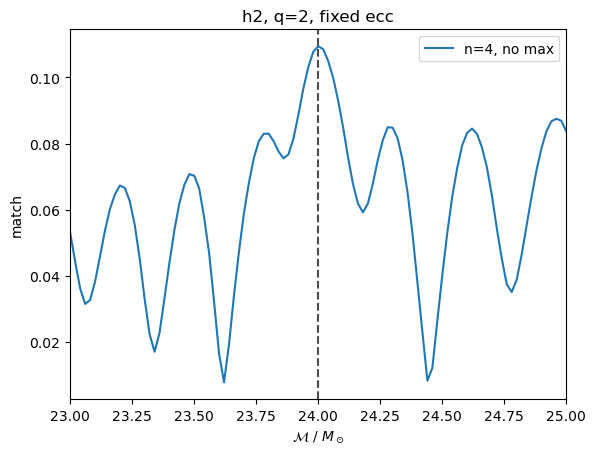

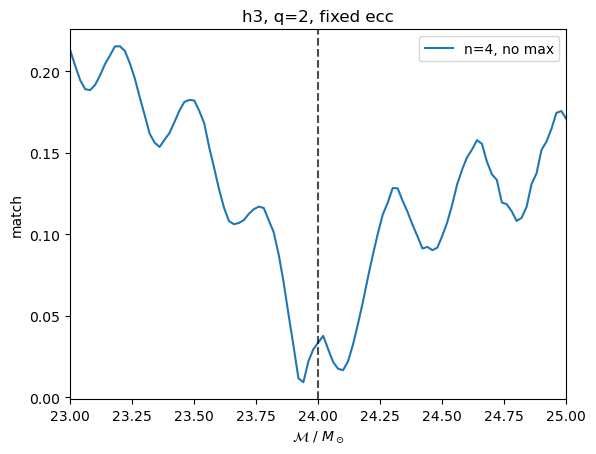

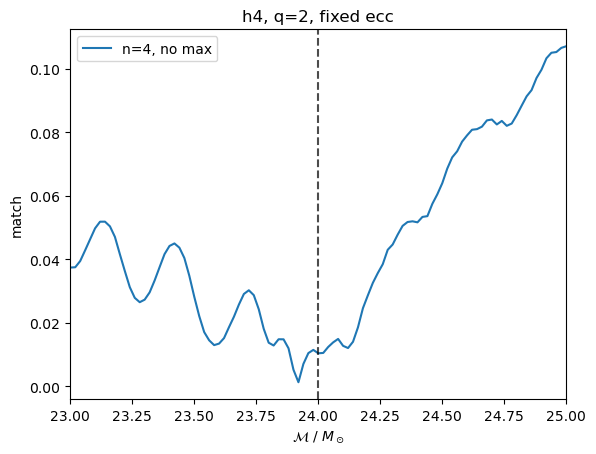

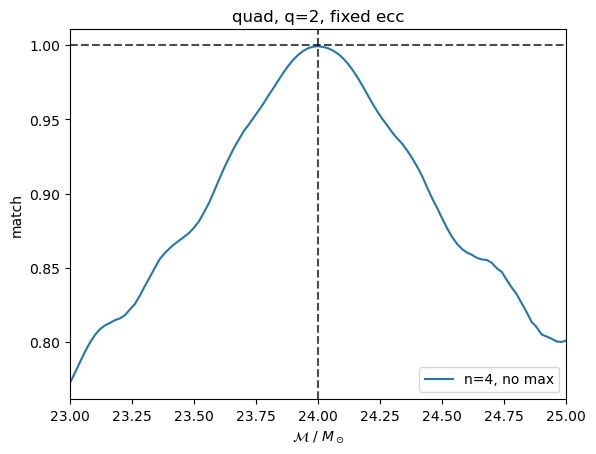

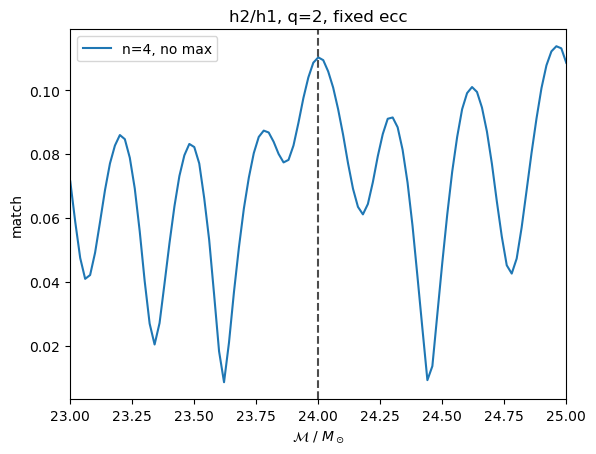

In [35]:
chirp_match_plot(np.linspace(23,25,101), 4, 0.1, 24, 2, [dataslot_1], ['n=4, no max'])

# n=2, phase difference, shift h, against chirp

In [13]:
start = time.time()
dataslot_2 = chirp_match_data(np.linspace(23,25,101), 2, 0.1, 24, 2, 10, match_method=shift_h)
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

101 done out of 101
Time taken: 107.79475688934326 seconds.


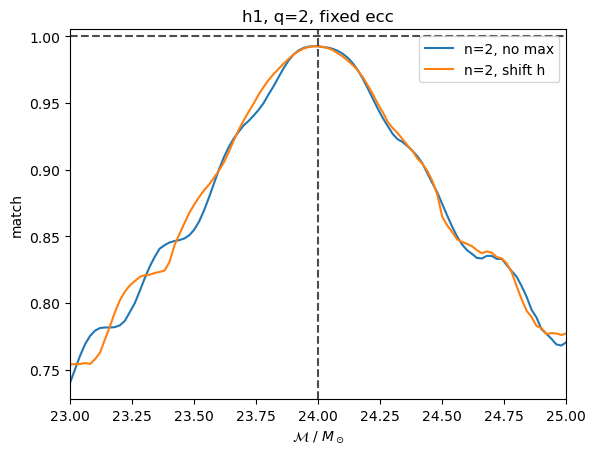

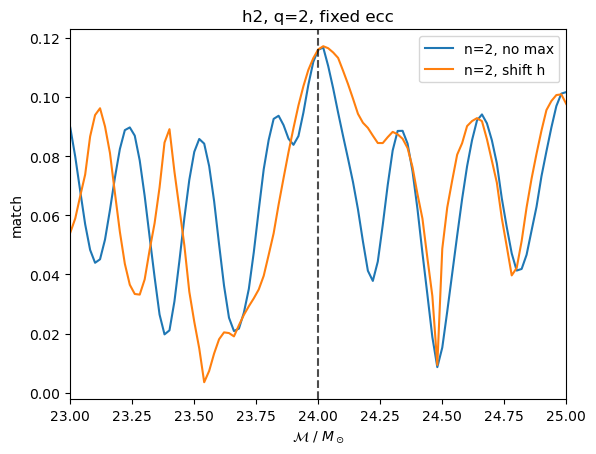

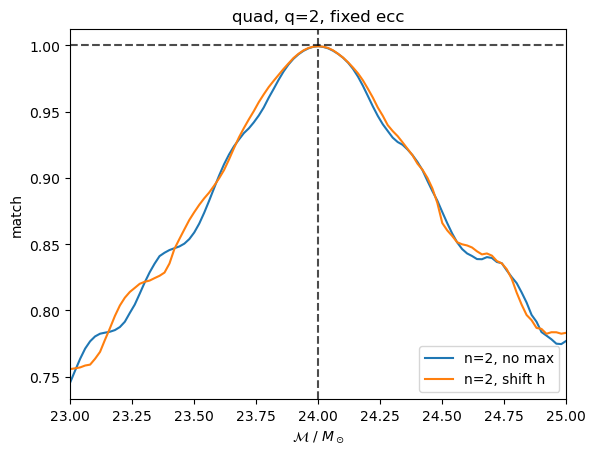

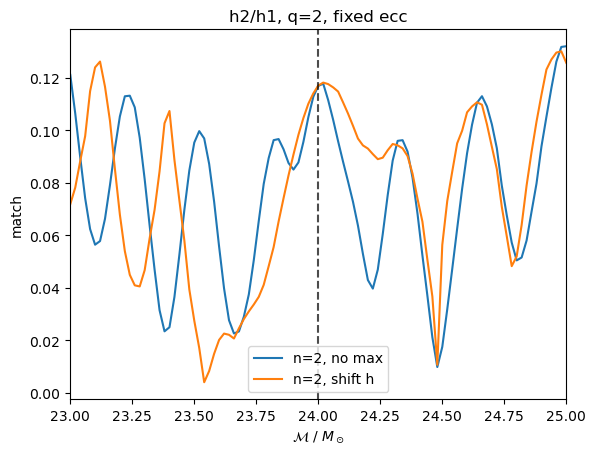

In [36]:
chirp_match_plot(np.linspace(23,25,101), 2, 0.1, 24, 2, [dataslot_0, dataslot_2], ['n=2, no max', 'n=2, shift h'])

# n=4, phase difference, shift h, against chirp

In [15]:
start = time.time()
dataslot_3 = chirp_match_data(np.linspace(23,25,101), 4, 0.1, 24, 2, 10, match_method=shift_h)
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

101 done out of 101
Time taken: 119.6781895160675 seconds.


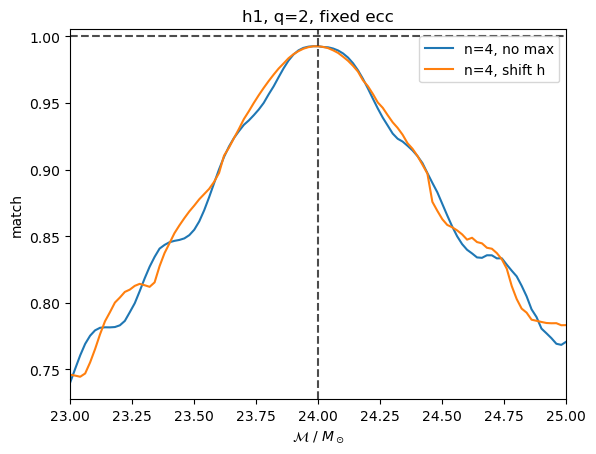

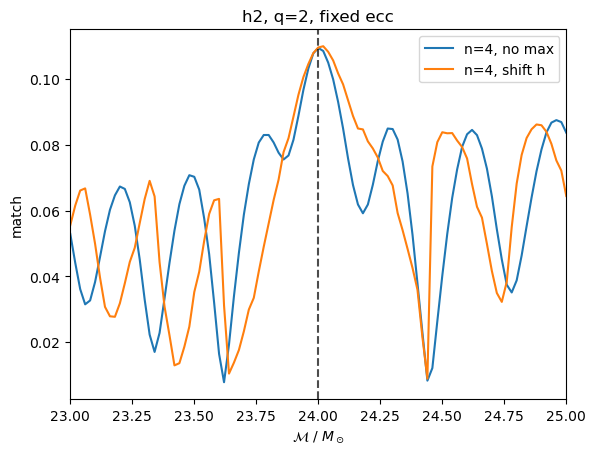

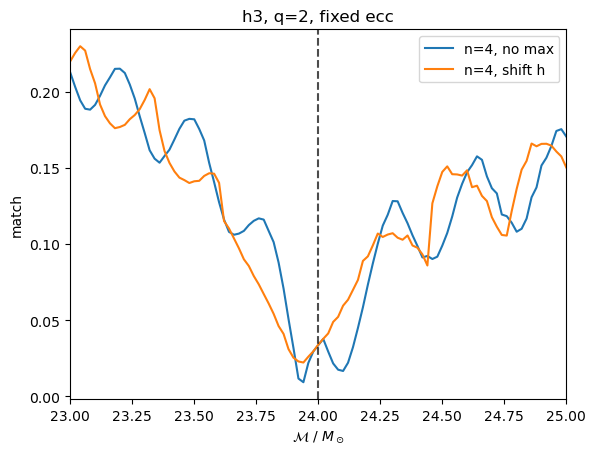

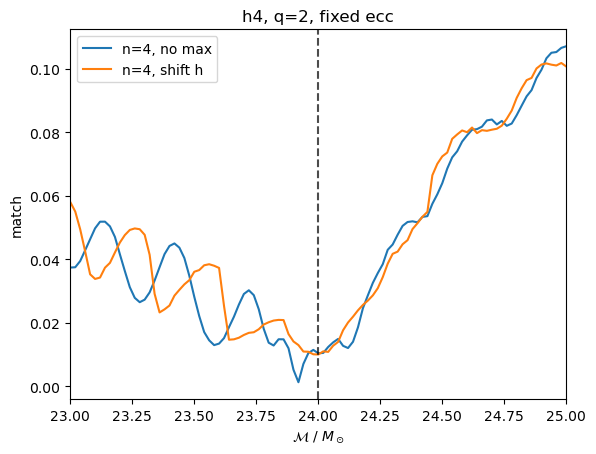

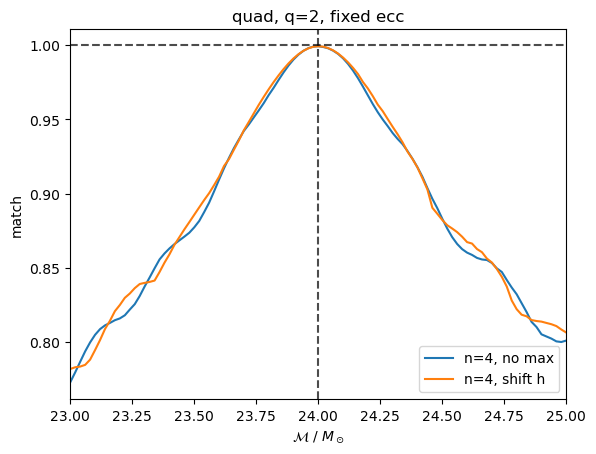

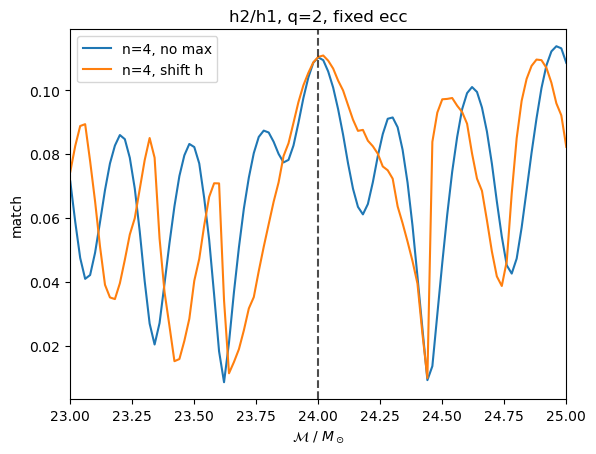

In [37]:
chirp_match_plot(np.linspace(23,25,101), 4, 0.1, 24, 2, [dataslot_1, dataslot_3], ['n=4, no max', 'n=4, shift h'])

# n=2, no maximisation, against ecc chirp

In [27]:
start = time.time()
dataslot_4 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.1, 24, 2, 10, param='ecc_chirp')
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

Average frequency: 29.736871508999073 Hz
Given_e shifted from 0.1 to 0.03165268397273404
101 done out of 101
Time taken: 52.477664947509766 seconds.


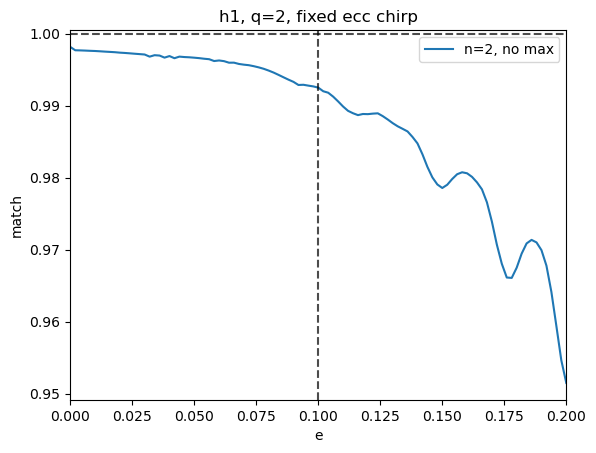

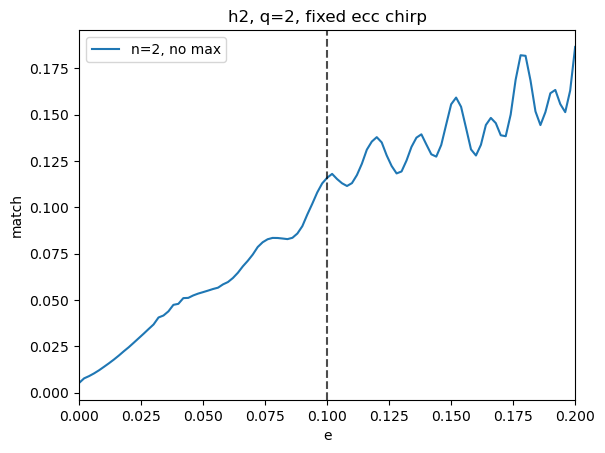

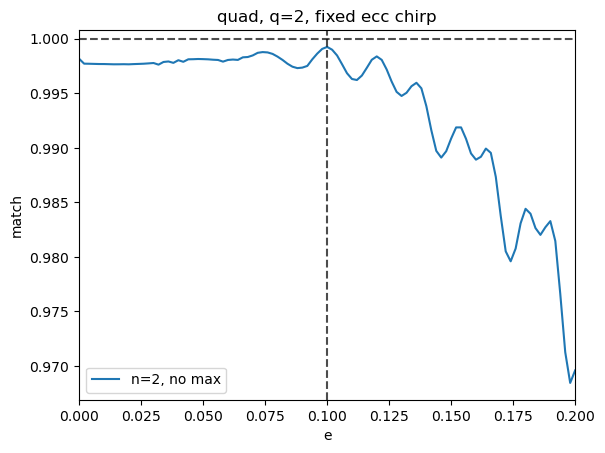

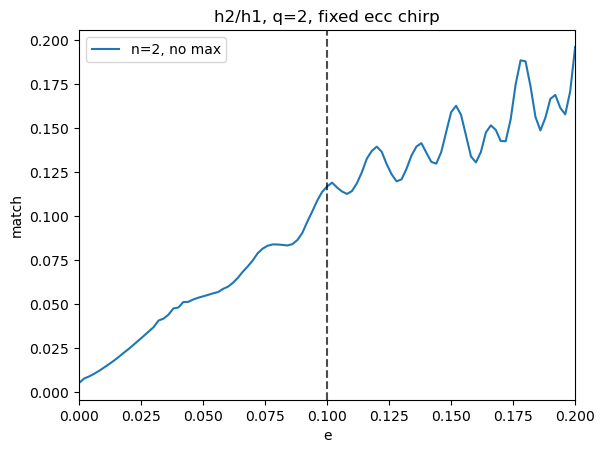

In [28]:
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.1, 24, 2, [dataslot_4], ['n=2, no max'], param='ecc_chirp')

# n=4, no maximisation, against ecc chirp

In [59]:
start = time.time()
dataslot_5 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.1, 24, 2, 10, param='ecc_chirp')
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

Average frequency: 29.736871508999073 Hz
Given_e shifted from 0.1 to 0.03165268397273404
101 done out of 101
Time taken: 66.80748629570007 seconds.


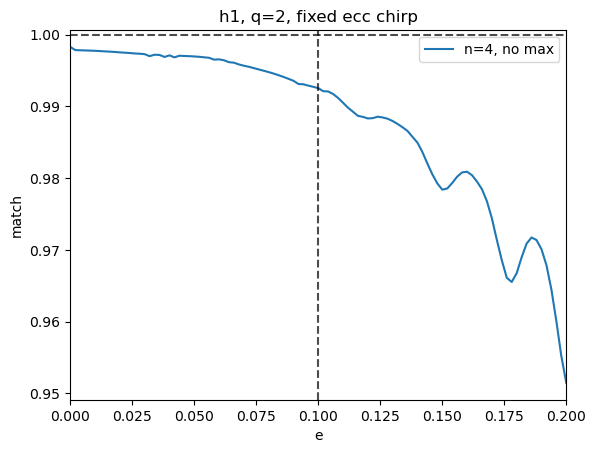

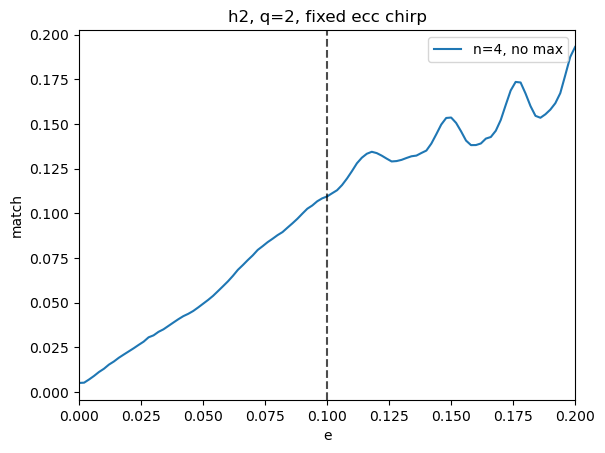

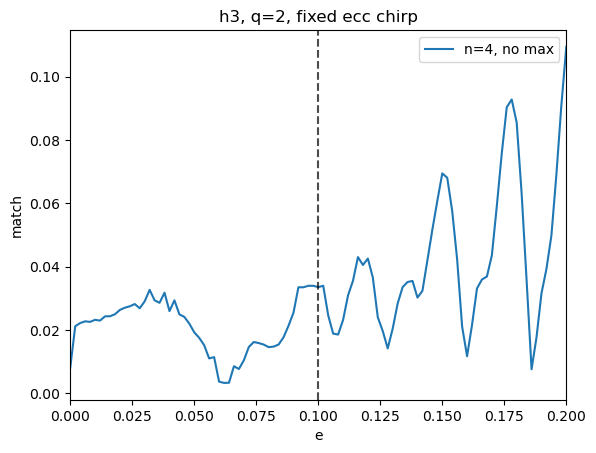

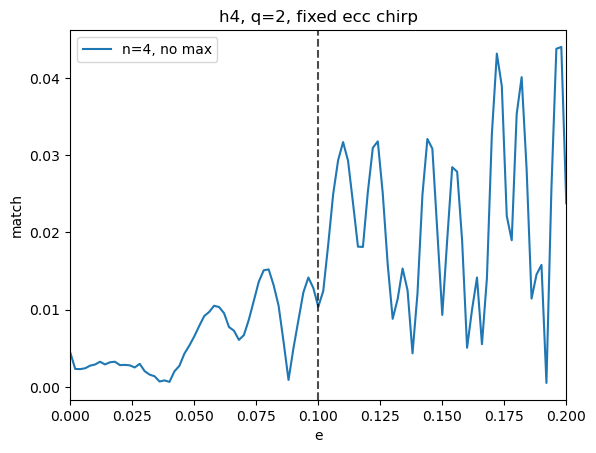

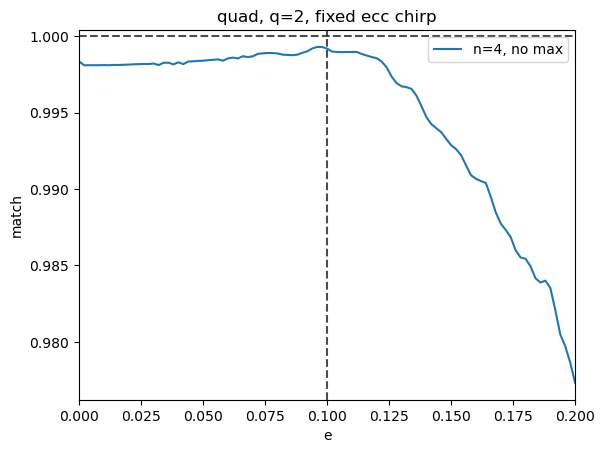

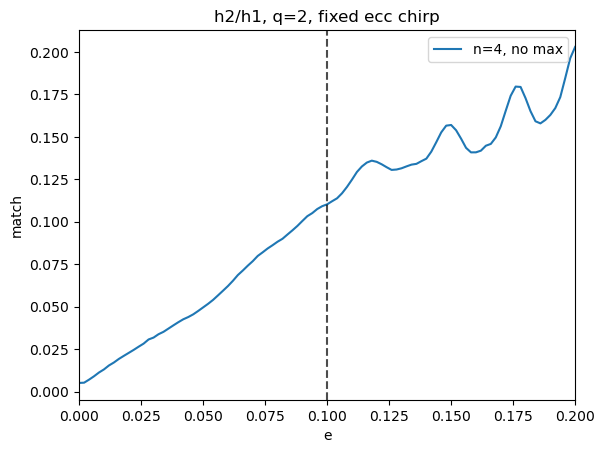

In [60]:
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.1, 24, 2, [dataslot_5], ['n=4, no max'], param='ecc_chirp')

# n=2, phase difference, shift h, against ecc chirp

In [25]:
start = time.time()
dataslot_6 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.1, 24, 2, 10, match_method=shift_h, param='ecc_chirp')
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

Average frequency: 29.736871508999073 Hz
Given_e shifted from 0.1 to 0.03165268397273404
101 done out of 101
Time taken: 105.48677897453308 seconds.


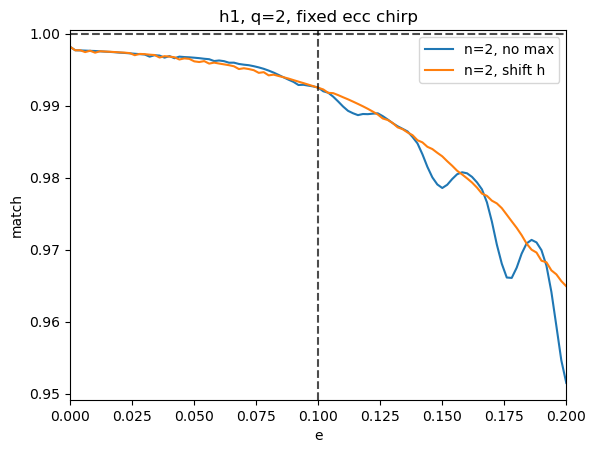

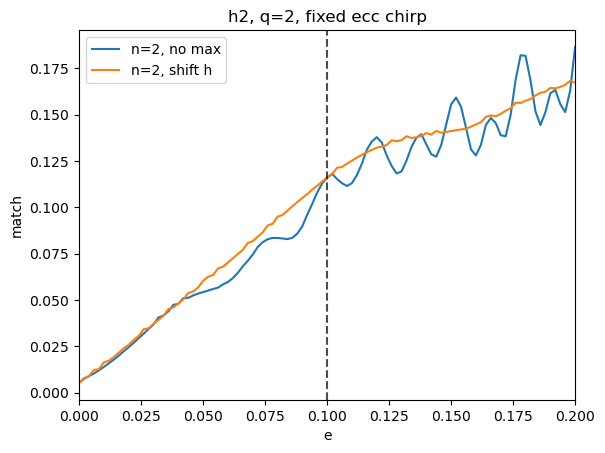

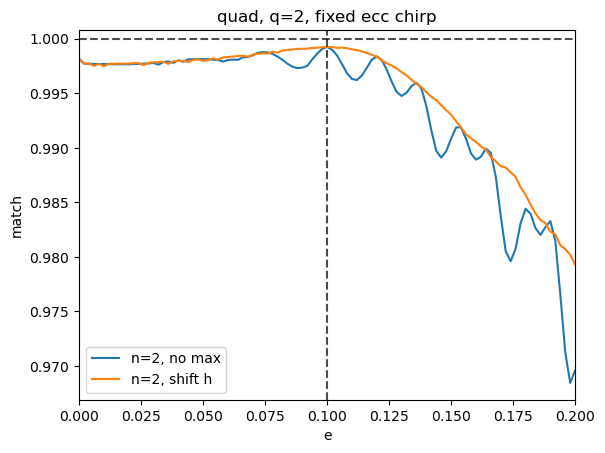

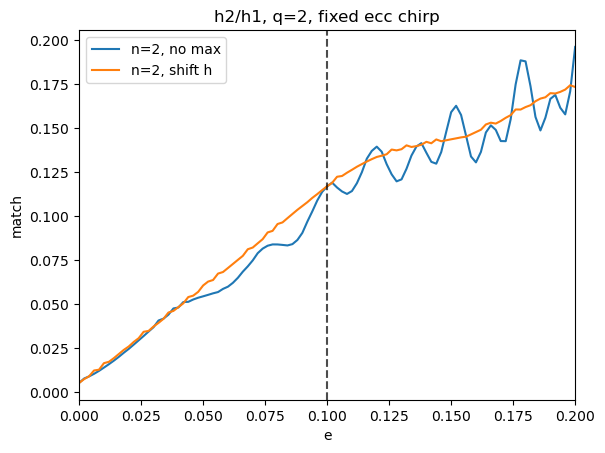

In [29]:
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.1, 24, 2, [dataslot_4, dataslot_6], ['n=2, no max', 'n=2, shift h'], param='ecc_chirp')

# n=4, phase difference, shift h, against ecc chirp

In [61]:
start = time.time()
dataslot_7 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.1, 24, 2, 10, match_method=shift_h, param='ecc_chirp')
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

Average frequency: 29.736871508999073 Hz
Given_e shifted from 0.1 to 0.03165268397273404
101 done out of 101
Time taken: 270.6914520263672 seconds.


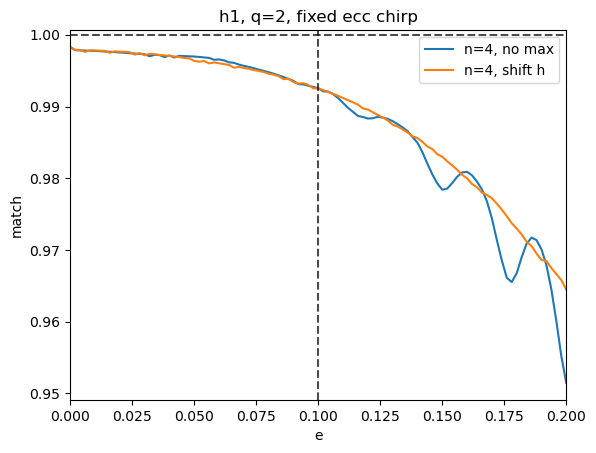

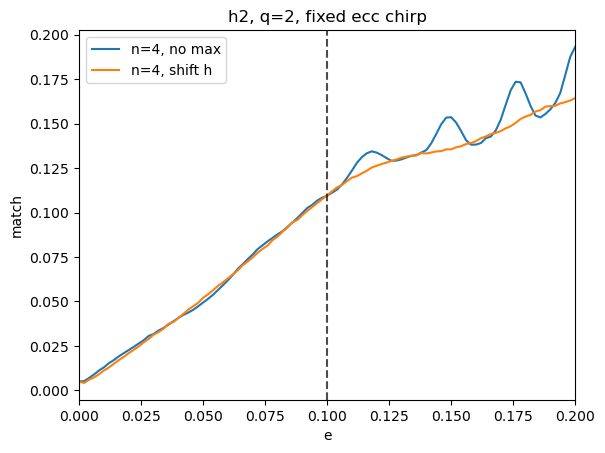

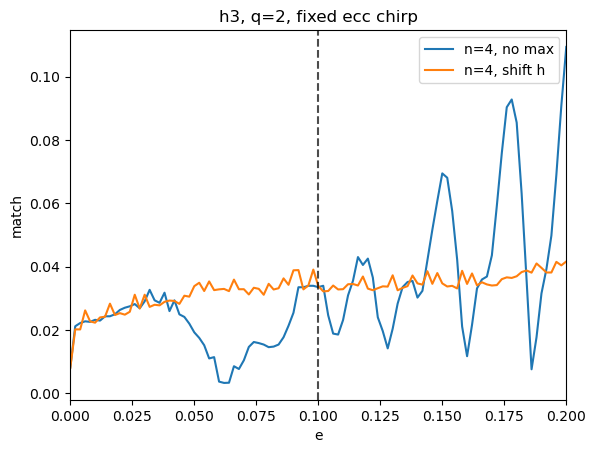

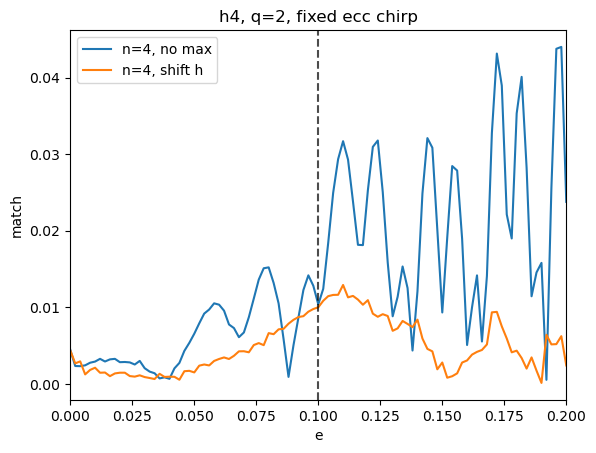

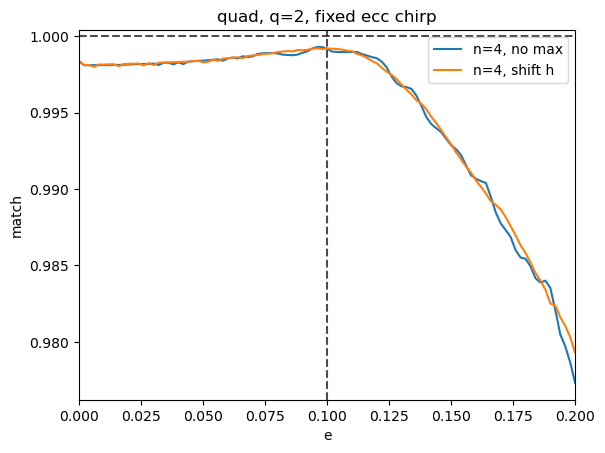

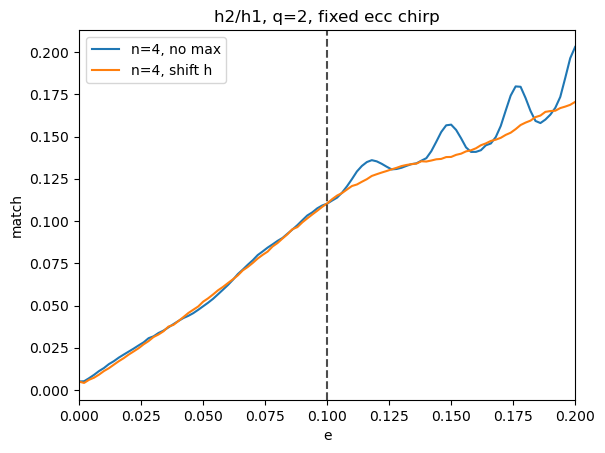

In [62]:
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.1, 24, 2, [dataslot_5, dataslot_7], ['n=4, no max', 'n=4, shift h'], param='ecc_chirp')

# n=2, phase difference, shift hn, against ecc chirp

In [ ]:
start = time.time()
dataslot_8 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.1, 24, 2, 10, match_method=shift_hn, param='ecc_chirp')
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

In [ ]:
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.1, 24, 2, [dataslot_4, dataslot_6, dataslot_8], ['n=2, no max', 'n=2, shift h', 'n=2, shift hn'], param='ecc_chirp')

# n=4, phase difference, shift hn, against ecc chirp

In [63]:
start = time.time()
dataslot_9 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.1, 24, 2, 10, match_method=shift_hn, param='ecc_chirp')
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

Average frequency: 29.736871508999073 Hz
Given_e shifted from 0.1 to 0.03165268397273404
101 done out of 101
Time taken: 575.424843788147 seconds.


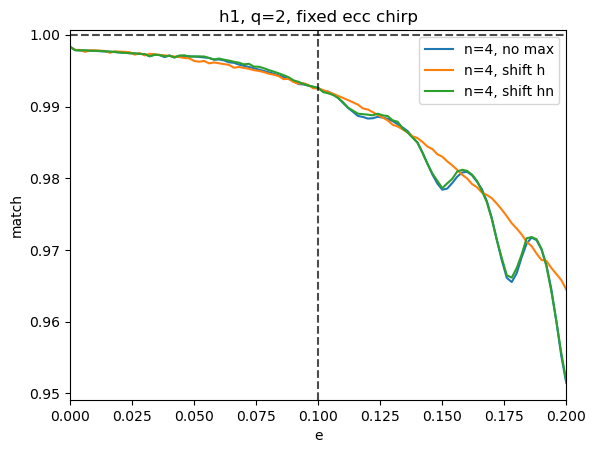

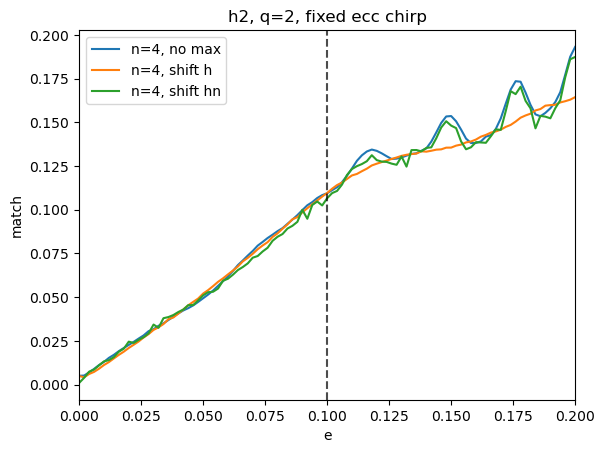

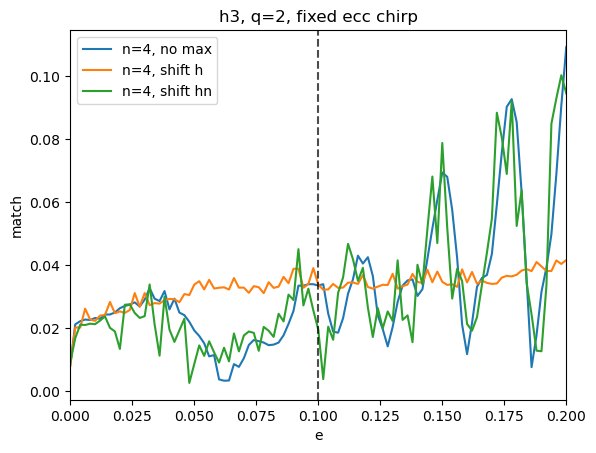

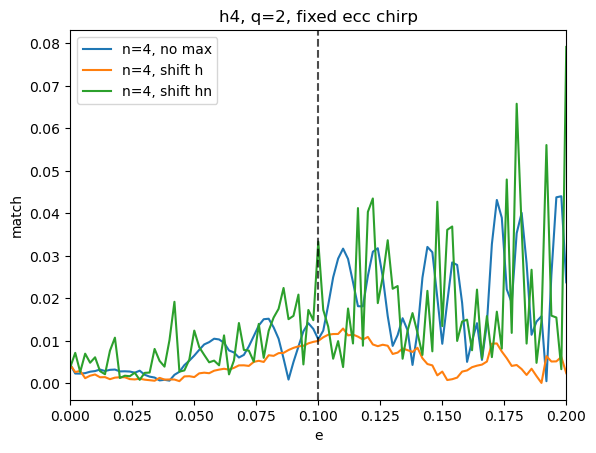

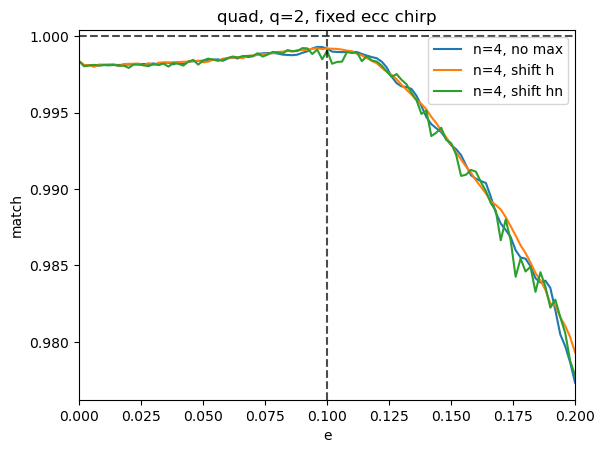

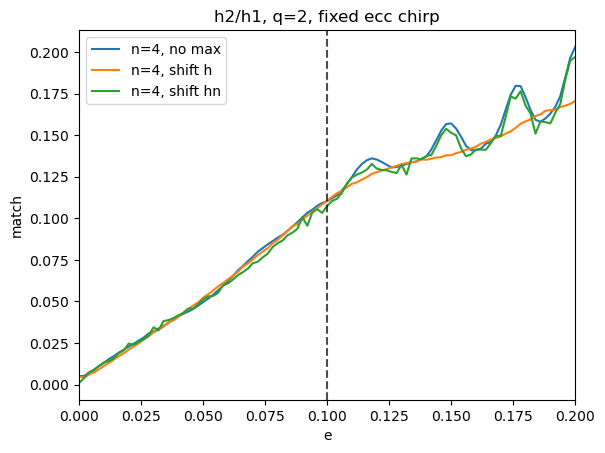

In [64]:
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.1, 24, 2, [dataslot_5, dataslot_7, dataslot_9], ['n=4, no max', 'n=4, shift h', 'n=4, shift hn'], param='ecc_chirp')

# n=2, phase difference, shift h + pi, against ecc chirp

In [30]:
start = time.time()
dataslot_10 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.1, 24, 2, 10, match_method=shift_h_pi, param='ecc_chirp')
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

Average frequency: 29.736871508999073 Hz
Given_e shifted from 0.1 to 0.03165268397273404
101 done out of 101
Time taken: 107.94335889816284 seconds.


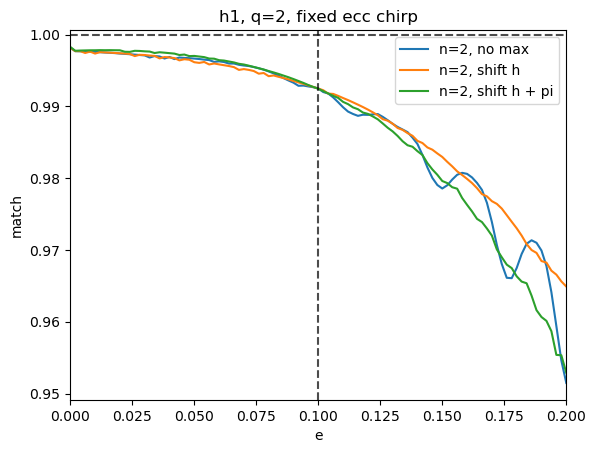

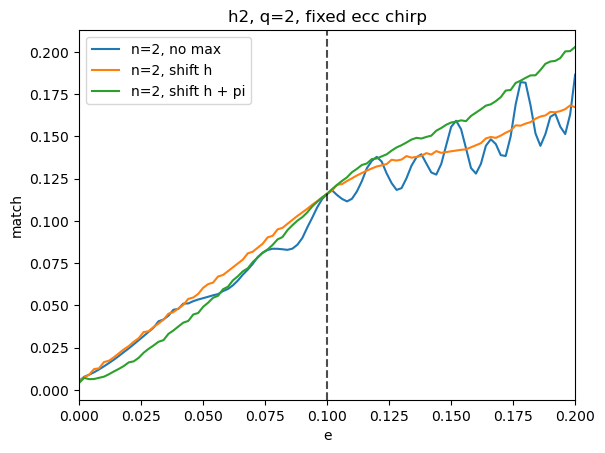

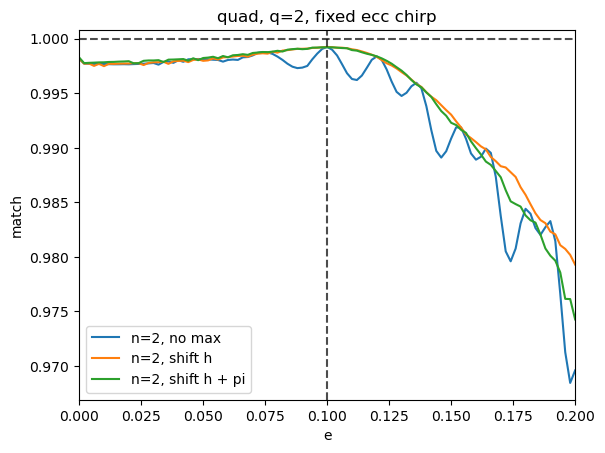

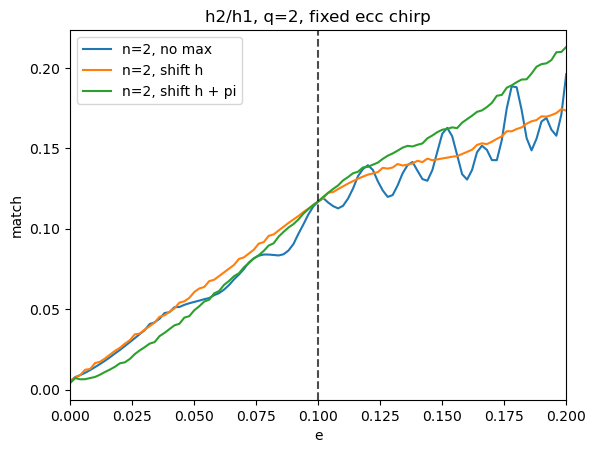

In [31]:
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.1, 24, 2, [dataslot_4, dataslot_6, dataslot_10], ['n=2, no max', 'n=2, shift h', 'n=2, shift h + pi'], param='ecc_chirp')

# n=4, phase difference, shift h + pi, against ecc chirp

In [65]:
start = time.time()
dataslot_11 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.1, 24, 2, 10, match_method=shift_h_pi, param='ecc_chirp')
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

Average frequency: 29.736871508999073 Hz
Given_e shifted from 0.1 to 0.03165268397273404
101 done out of 101
Time taken: 909.7639336585999 seconds.


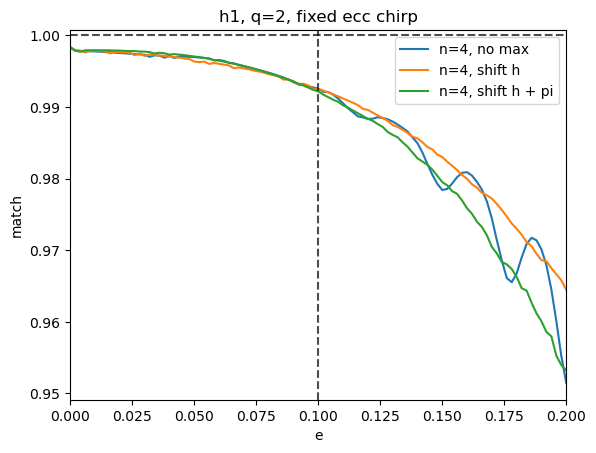

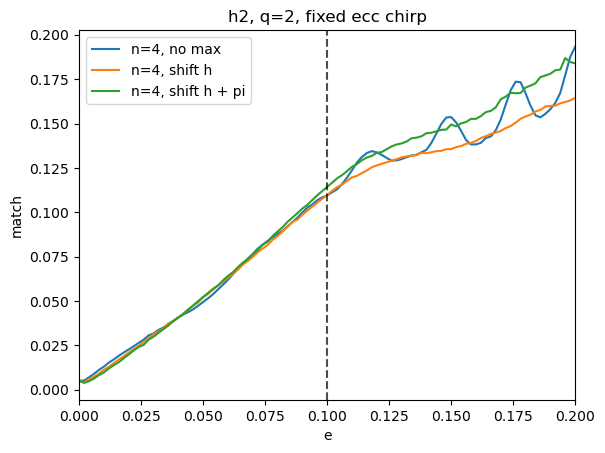

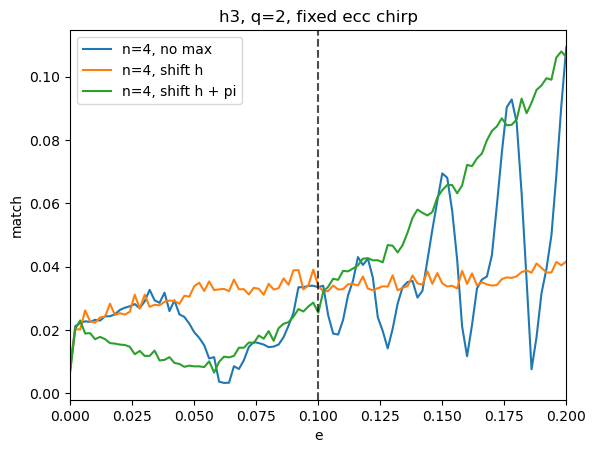

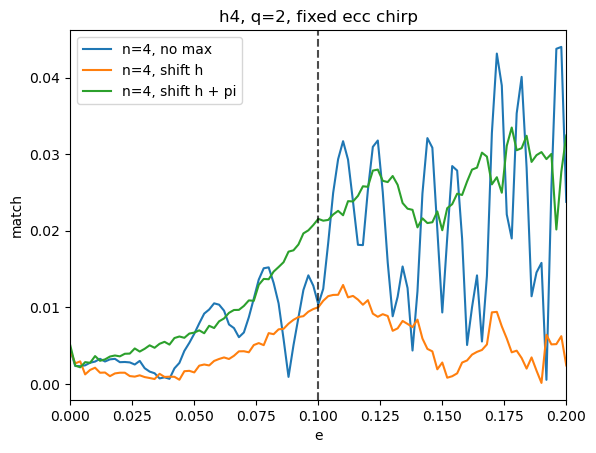

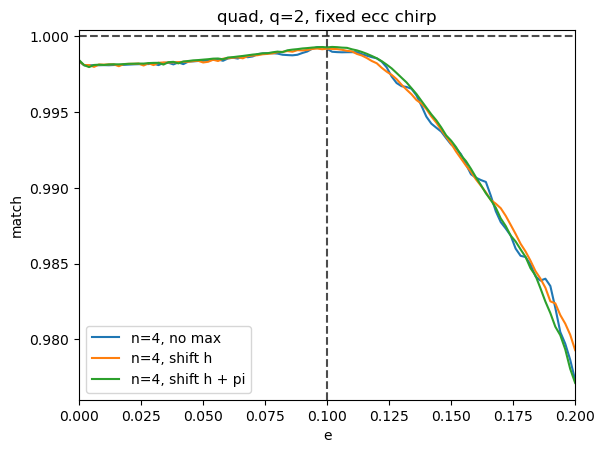

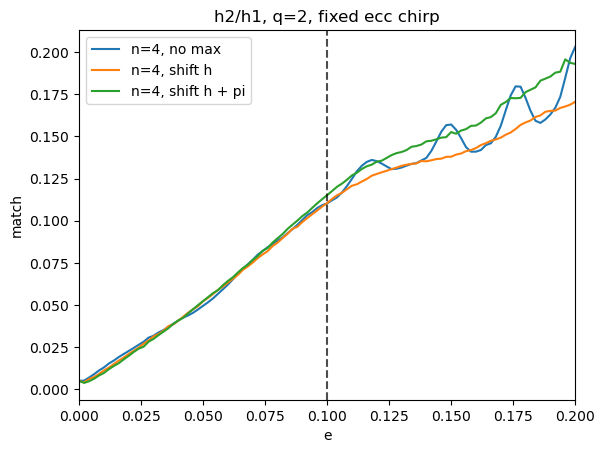

In [66]:
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.1, 24, 2, [dataslot_5, dataslot_7, dataslot_11], ['n=4, no max', 'n=4, shift h', 'n=4, shift h + pi'], param='ecc_chirp')

# n=2, phase difference, shift h + sine, against ecc chirp

In [131]:
start = time.time()
dataslot_12 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.1, 24, 2, 10, TA_method=get_TA_sine, match_method=shift_h, param='ecc_chirp')
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

Average frequency: 29.736871508999076 Hz
Given_e shifted from 0.1 to 0.03165268397273404
Average frequency: 29.736871508999076 Hz
Given_e shifted from 0.1 to 0.03165268397273404
[-0.02124201]
101 done out of 101
Time taken: 157.56229090690613 seconds.


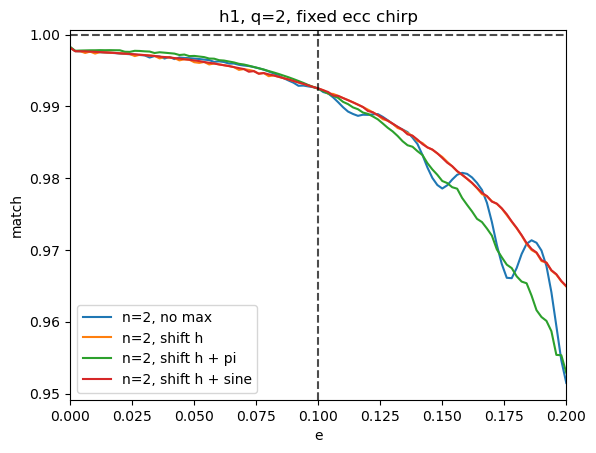

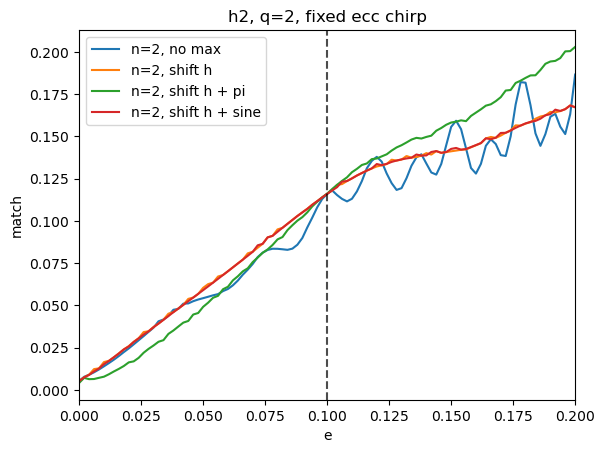

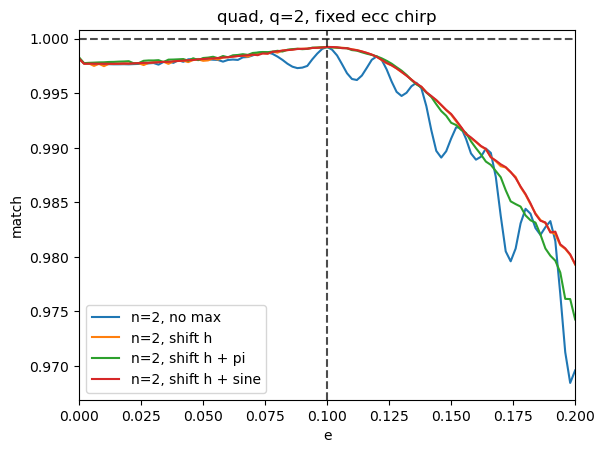

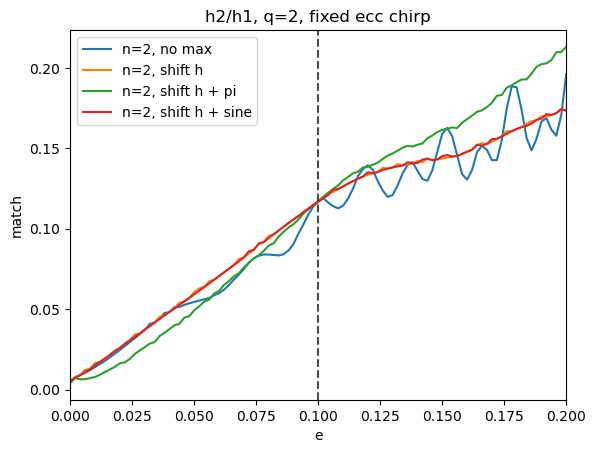

In [132]:
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.1, 24, 2, [dataslot_4, dataslot_6, dataslot_10, dataslot_12], ['n=2, no max', 'n=2, shift h', 'n=2, shift h + pi', 'n=2, shift h + sine'], param='ecc_chirp')

# n=4, phase difference, shift h + sine, against ecc chirp

In [133]:
start = time.time()
dataslot_13 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.1, 24, 2, 10, TA_method=get_TA_sine, match_method=shift_h, param='ecc_chirp')
end = time.time()
print(f'\nTime taken: {end-start} seconds.')

Average frequency: 29.736871508999073 Hz
Given_e shifted from 0.1 to 0.03165268397273404
Average frequency: 29.736871508999073 Hz
Given_e shifted from 0.1 to 0.03165268397273404
[-5.63937876]
101 done out of 101
Time taken: 139.84067821502686 seconds.


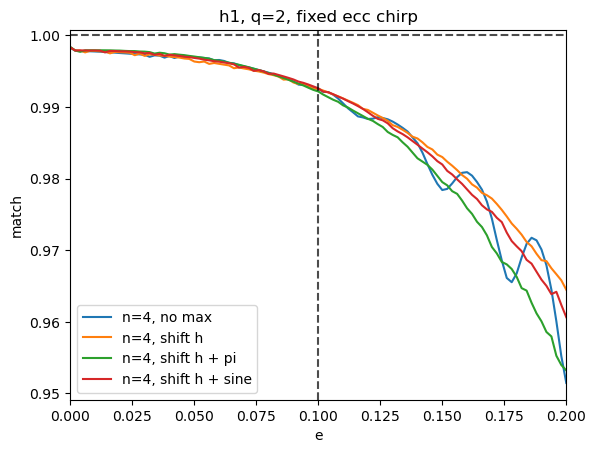

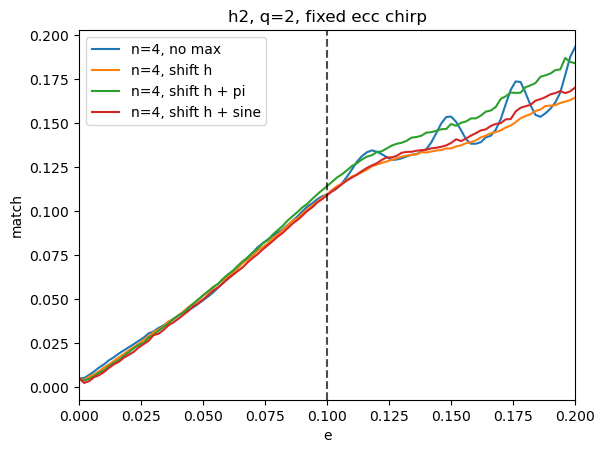

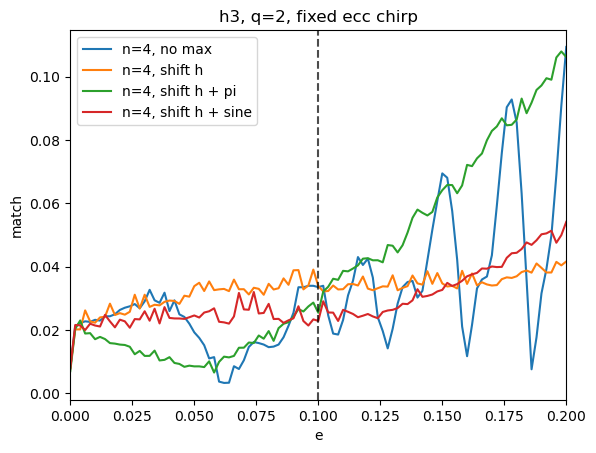

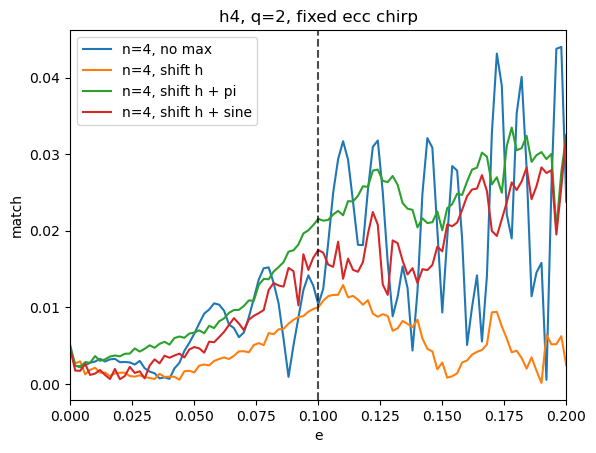

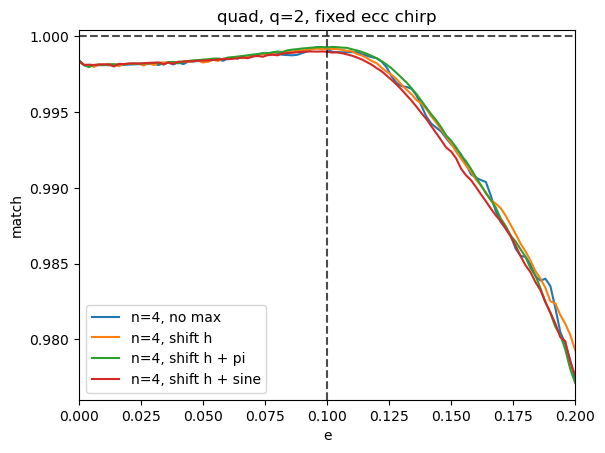

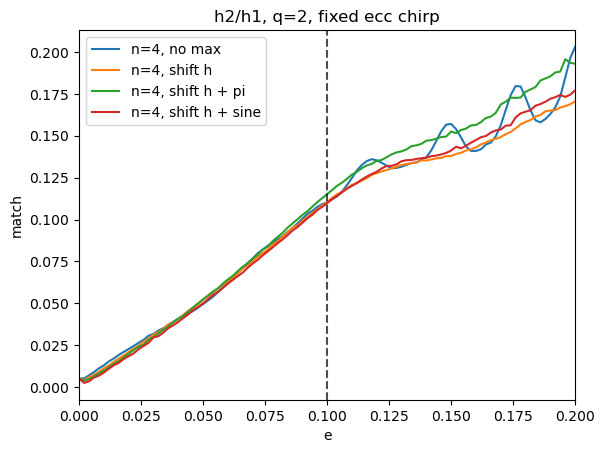

In [134]:
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.1, 24, 2, [dataslot_5, dataslot_7, dataslot_11, dataslot_13], ['n=4, no max', 'n=4, shift h', 'n=4, shift h + pi', 'n=4, shift h + sine'], param='ecc_chirp')